# Examen Parcial 2 - Daniel Enríquez 202308323


### About Dataset
Machine Predictive Maintenance Classification Dataset
Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in the industry to the best of our knowledge.

The dataset consists of 10 000 data points stored as rows with 14 features in columns

- UID: unique identifier ranging from 1 to 10000
- productID: consisting of a letter L, M, or H for: low (50% of all products), medium (30%), and high (20%) as product quality variants and a variant-specific serial number
- air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- rotational speed [rpm]: calculated from powepower of 2860 W, overlaid with a normally distributed noise
- torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.
- tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
- 'machine failure' label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true.

### Important : 
There are two Targets - Do not make the mistake of using one of them as feature, as it will lead to leakage.
- Target : Failure or Not
- Failure Type : Type of Failure


> **Nota importante:** Para este examen vamos a utilizar la variable objetivo, **Target** es binaria si la maquina fallo o no, la otra variable hay que eliminarla ya que puede causar data leakage

> **Pregunta 1:** Investigar y explicar en un parrafo en formato markdown que es el **data leakage** y como esta puede afectar a nuestro modelo de ML, especificamente en este caso porque hay que eliminar una de las variables objetivo

#### $\rightarrow$ Leakage $\leftarrow$ ####
El leakage en ML es un error metodológico en el diseño del modelo que queremos entrenar. Este se da cuando el modelo tiene acceso a información que no debería tener, en sentido que tiene información que en una situación dada en la vida real no se tendría, o tiene información del futuro.
Esto lo ayuda a ser un modelo que rinde bien en pruebas y validez, pero no puede producir información realmente, pues sobreestima valores.

En nuestro caso, el otorgarle acceso al tipo de error dado en la maquinaria le ayudaría a dilucidar secamente que fallas habían, sin poder entonces realmente predecirlas.

## Carga de datos

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv("predictive_maintenance.csv")

In [3]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure


## Preprocesamiento de datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


### Validacion de datos Null o dupicados

In [5]:
data.isnull().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
data.duplicated().sum()

0

### Entendiendo los tipos de datos y valores unicos

In [7]:
data.dtypes

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Target                       int64
Failure Type                object
dtype: object

In [8]:
data.nunique()

UDI                        10000
Product ID                 10000
Type                           3
Air temperature [K]           93
Process temperature [K]       82
Rotational speed [rpm]       941
Torque [Nm]                  577
Tool wear [min]              246
Target                         2
Failure Type                   6
dtype: int64

In [9]:
data['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

> **Pregunta 2:** Que entiendes de el analisis anterior

Notemos ante todo, que como se decía en las especificaciones del DataSet, tenemos $10,000$ registros, en los cuales no se tiene ningún valor nulos ni registros repetidos por el método *duplicated* e *isnull* devolver $0$.

Seguidamente podemos observar como **UDI** es un entero, así como **Rotational speed**, **Tool wear** y **Target**; **Air temperature** un decimal, así como **Process Temperature**, **Torque**; los otros son de tipo objeto, sin determinar a fin que tipo. 

Seguidamente podemos observar con el método *nunique* que efectivamente hay $10,000$ productos, de $3$ y $6$ tipos de error, nuestro **Target** es solamente si hay error o no.  

Del tipo de producto podemos darnos cuenta con *value_counts* que la más abundante es la de baja calidad con $6,000$ unidades, $2,997$ para mediana y $1,003$ para alta.

### Eliminar identificadores
Elimina las variables
- UDI
- Product ID
- Failure Type


Tip: utiliza la función `drop`de pandas

In [10]:
data.drop(columns=['UDI', 'Product ID', 'Failure Type'])

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0
...,...,...,...,...,...,...,...
9995,M,298.8,308.4,1604,29.5,14,0
9996,H,298.9,308.4,1632,31.8,17,0
9997,M,299.0,308.6,1645,33.4,22,0
9998,H,299.0,308.7,1408,48.5,25,0


### Verificamos si el dataset esta balancado

Tip: Utiliza la funcion de pandas `value_counts()` 

In [11]:
data['Target'].value_counts(normalize=True)

Target
0    0.9661
1    0.0339
Name: proportion, dtype: float64

> **Pregunta 3:** Esta balanceado o no el dataset, que estrategias hay para un dataset no balanceado

Está totalmente desbalanceado, notemos como la primera clase aparece el 96% de las veces, mientras que la otra solo el 3%; casi no hay fallas, realmente fueron difíciles y son casos atípicos las fallas. Esto nos deja al modelo mal entrenado por predecir siempre 0 (no hay), mientr
as no que sabrá distinguir mucho y no podrá decir cuando realmente las hay (no hay muchos ejemplos de cuando se falla).

Además, hagamos la súper importante distinción de nuestra variable **Target** ser categórica, pues es de carácter 0, o 1.

Ahora, cuando tenemos un dataset desbalanceado, podemos utilizar las siguientes estrategias:

1. *Resampling*: puede ser realizado en <u>sobremuestreo</u> (aumentar la clase minoritaria), o <u>submuestreo</u> (reducir la clase mayoritaria).
2. Uso de algoritmos: podemos ajustar el peso de las clases con algoritmos que balancean la data, o modificarlos manualmente.
3. Cambiar la métrica de evaluación.

### Creamos dos variables nuevas
- temperature_difference: diferencia entre la temperatura de el aire y la del proceso
- Mechanical Power (W):

$$
P = \frac{T \cdot 2\pi \cdot N}{60}
$$
Donde:

- $P$ es la potencia en W,
- $T$ es el torque en Nm,
- $N$ es la velocidad en rpm,
- $\frac{2\pi}{60}$ convierte rpm a rad/s.

Aplicandolo a la data:
$$
\text{Potencia (W)} = \frac{\text{Torque (Nm)} \cdot \text{Velocidad (rpm)} \cdot 2 \cdot \pi}{60}
$$

In [91]:
data['temperature_difference']=(data['Air temperature [K]']-data['Process temperature [K]'])
data['temperature_difference']

0      -10.5
1      -10.5
2      -10.4
3      -10.4
4      -10.5
        ... 
9995    -9.6
9996    -9.5
9997    -9.6
9998    -9.7
9999    -9.7
Name: temperature_difference, Length: 10000, dtype: float64

In [92]:
data['Mechanical Power [W]']= (data['Torque [Nm]']*2*np.pi*data['Rotational speed [rpm]']/60)
data['Mechanical Power [W]']

0       6951.590560
1       6826.722724
2       7749.387543
3       5927.504659
4       5897.816608
           ...     
9995    4955.129373
9996    5434.703963
9997    5753.617506
9998    7151.102638
9999    6314.601234
Name: Mechanical Power [W], Length: 10000, dtype: float64

In [49]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,temperature_difference,Mechanical Power [W]
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,-10.5,6951.590560
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,-10.5,6826.722724
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,-10.4,7749.387543
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,-10.4,5927.504659
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,-10.5,5897.816608
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,No Failure,-9.6,4955.129373
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,No Failure,-9.5,5434.703963
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,No Failure,-9.6,5753.617506
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,No Failure,-9.7,7151.102638


## Analisis de Datos Exploratorio

#### Visualización de Tipos de maquina
Grafica la distribución de tipos de maquina

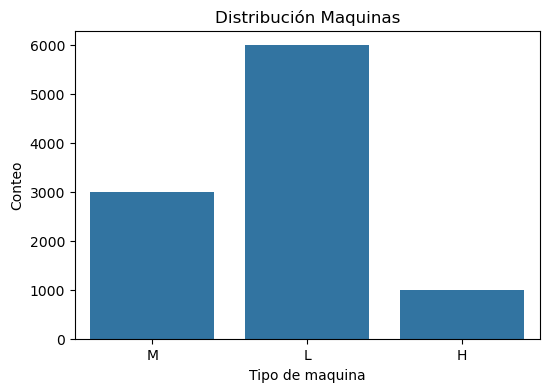

In [39]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', data=data)
plt.title('Distribución Maquinas')
plt.xlabel('Tipo de maquina')
plt.ylabel('Conteo')
plt.show()

#### Visualización de la distribución de fallos entre tipos de productos

Muestra cómo se distribuyen los fallos entre los tipos: ¿es posible que algunos tipos de maquina fallan más?

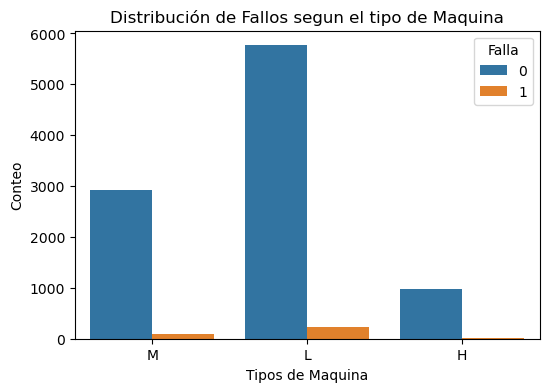

In [40]:
plt.figure(figsize=(6,4))
sns.countplot(x='Type', hue='Target', data=data)
plt.title('Distribución de Fallos segun el tipo de Maquina')
plt.xlabel('Tipos de Maquina')
plt.ylabel('Conteo')
plt.legend(title='Falla')
plt.show()

Notemos como las máquinas que trabajan con calidad:
- **Media**: fallan a intermedio.
- **Más baja**: fallan como las que más.
- **Más alta**: fallan menos.

Dándonos apertura a la posible conclusión de: <u>las máquinas que trabajan a calidad baja son las que más fallan</u>.

### Grafico de distribuciones 
Graficamos las distribuciones de las variables numericas para observar anomalias y patrones en los datos.



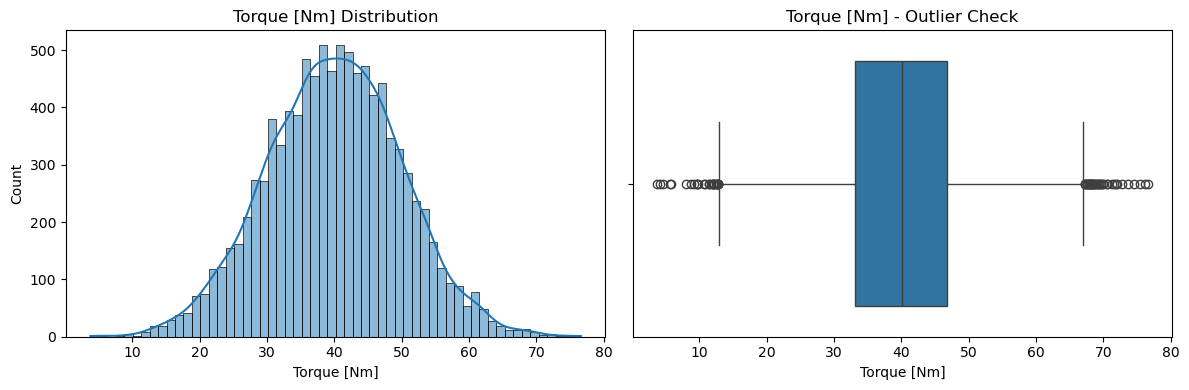

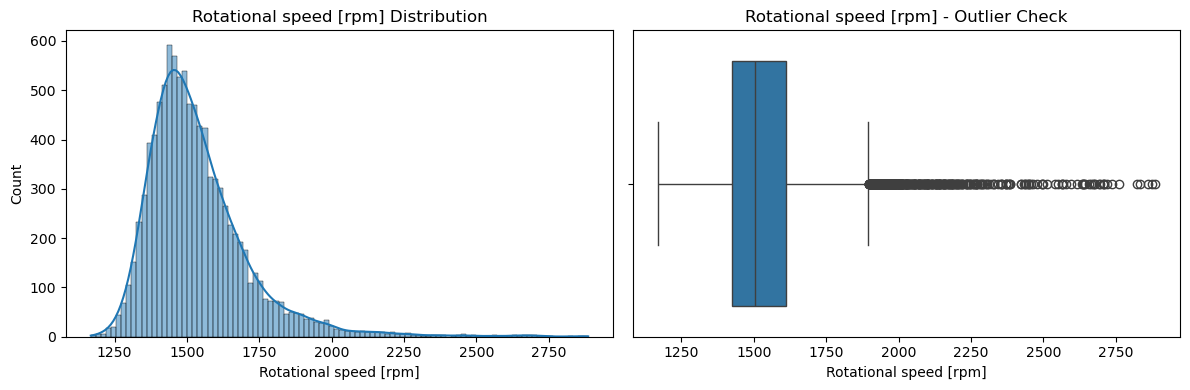

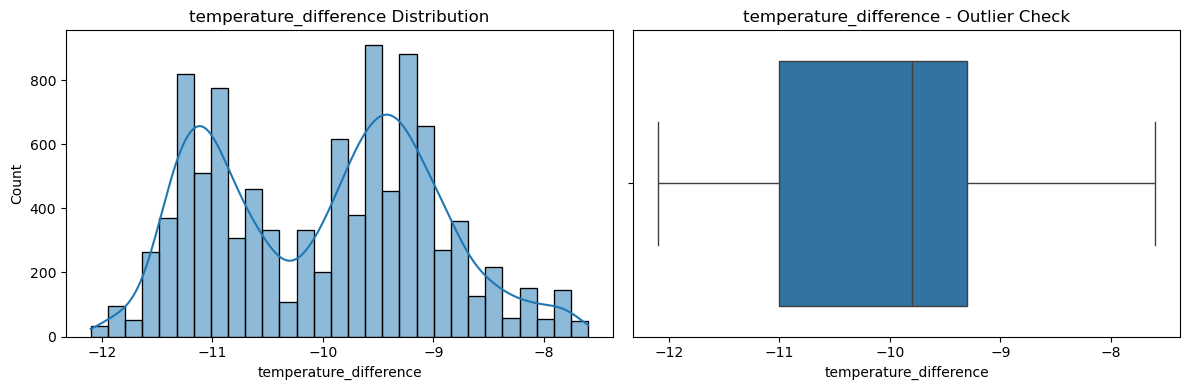

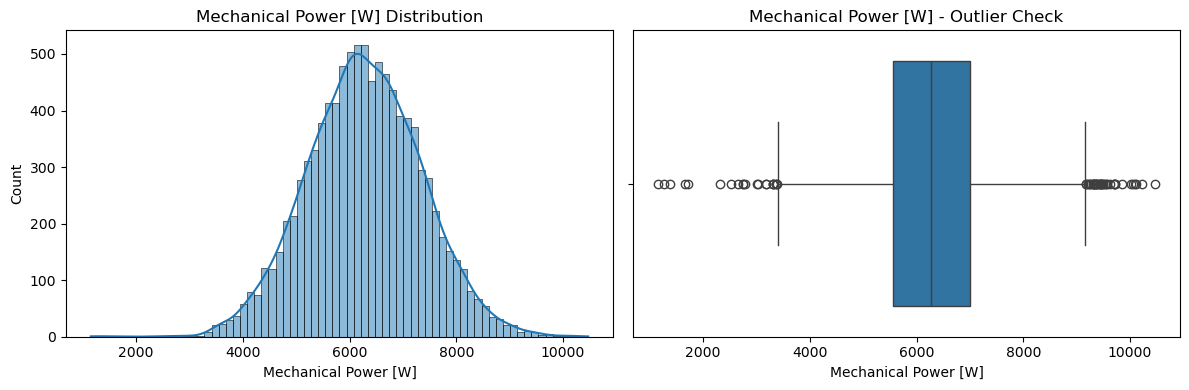

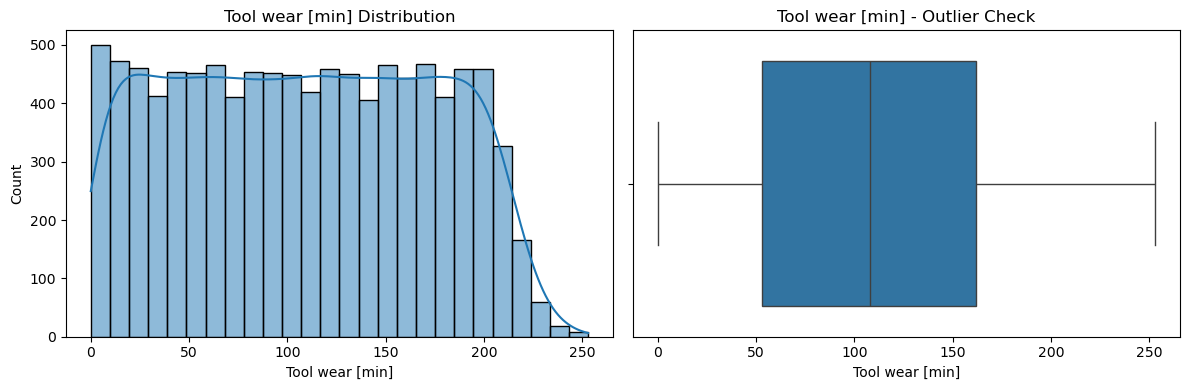

In [45]:
cols = [
    'Torque [Nm]', 'Rotational speed [rpm]', 
    'temperature_difference', 'Mechanical Power [W]',
    'Tool wear [min]',
]

for col in cols:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

    # Histogram with KDE
    sns.histplot(data=data, x=col, kde=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution")

    # Boxplot
    sns.boxplot(data=data, x=col, ax=axes[1])
    axes[1].set_title(f"{col} - Outlier Check")

    plt.tight_layout()
    plt.show()

> **Pregunta 4:** Describe que entiendes de la grafica anterior

Notemos que:
- **El torque** tiene una distribución estándar por la mayoría de sus datos desplegarse alrededor de $40$ Nm; en el *outlier check* podemos ver que tenemos presencia de valores atípicos y se dan en mayoría alrededor de $70$ Nm.
- En **la velocidad de rotación** observamos la misma situación de distribución normal, al tener sus datos aproximadamente desarrollados alrededor de $1400$ rpm, sin embargo, podemos ver una fuerte y clara presencia de valores atípicos desde las $1800$rpm en adelante. El problema es que son constantes, causándonos mucha  problemática por tantos valores atípicos.
- En el caso de la **diferencia de temperatura**, podemos observar como tenemos una distribución *bimodal*, pues aparentan "dos medias", esto pudiéndonos indicar sobre alguna diferencia de procesos o de turno; el caso es que deber de haber algo escondido que causa dichas ambas modas. En este caso el *outlier check* no nos da tanta información, pues tenemos a la data distribuida de una manera muy densa. Aquí sería más conveniente usar una segmentación o algo por el estilo para poder entender como se comportan los valores atípicos.
- La **potencia mecánica** sí tiene una distribución normal y podemos ver como se desarrollan los datos alrededor de $6000$ W, aproximadamente. Igualmente tenemos ciertos valores atípicos, pero no aparentan ser tantos y pareciera ser un caso normal.
- El **desgaste de herramienta** en este caso no tiene una distribución normal y no nos dice mucho realmente sobre como se distribuyen los datos, el análisis de *outlier* tampoco. Este tipo de variables no suelen decirnos mucho realmente por sí solas bajo estos análisis y se deben estudiar conjunto a otras...

### Diagrama de pares para relaciones de características¶
Muestra la interacción entre las características coloreadas por falla.

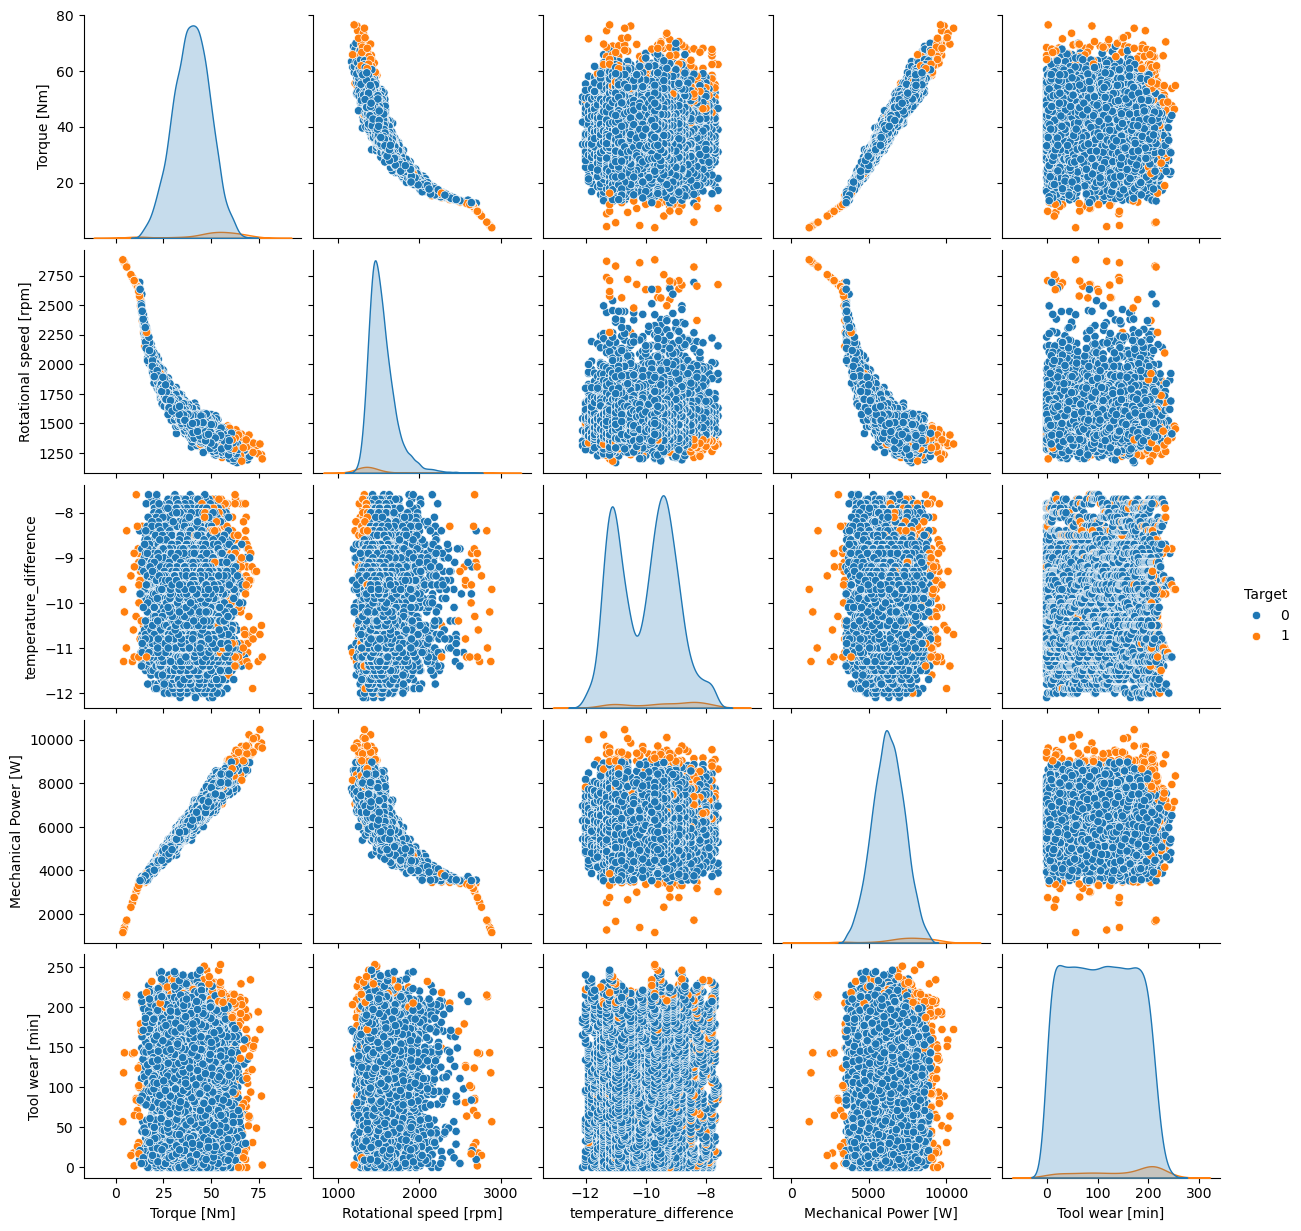

In [44]:
sns.pairplot(
    data[['Torque [Nm]', 'Rotational speed [rpm]', 
          'temperature_difference','Mechanical Power [W]','Tool wear [min]', 'Target']], 
    hue='Target'
)
plt.show()

Notemos que para:
#### El torque
y su desarrollo con:
- La velocidad rotacional: pareciera que solo con torcas muy altas y velocidades muy bajas hay fallos, así como con torcas muy bajas y velocidades muy altas.  
- La diferencia de temperatura: pareciera que solo cuando trabajamos con torcas muy fuertes se tienen fallas en la maquinaria, sin importar tanto de la temperatura. 
- La potencia mecánica: potencias muy bajas con torcas bajas causan errores, al igual que potencias muy altas con torcas muy altas. Al extremar ambas variables tendremos fallas.
- El tiempo de desgaste: pareciera que no importa que tanto tiempo se esté expuesta a desgaste la maquinaria con torcas intermedias, pues las fallas suelen darse cuando tenemos, nuevamente, torcas o muy bajas o muy altas.

#### La velocidad rotacional
y su desarrollo con:
- Diferencias de temperatura: pareciera que solo al trabajar con velocidades muy altas ocurrir fallas, sin importar la diferencia de temperatura ambiente, aunque aparentan haber fallas con temperaturas no tan distintas de la ambiente y velocidades bajas. 
- La potencia mecánica: los valores intermedios parecen mostrar buen funcionamiento, solo no se debe tener velocidades muy altas con potencias muy bajas, ni velocidades muy bajas con potencias muy altas.
- Tiempo de desgaste: fallas parecieran solo suceder cuando trabajamos con velocidades muy altas, sin importar tanto el tiempo de desgaste.


#### La diferencia de temperatura
y su desarrollo con:
- La potencia mecánica: pareciera no importar realmente la diferencia de respecto temperatura del exterior, mientras no se trabaje con potencias muy altas o bajas.
- El tiempo de desgaste: parecieran no ocasionarse fallas por variaciones en estas, ámbas suelen desarrollarse bien mutumente.

#### La potencia Mecánica
y su desarrollo con:
- El tiempo de desgaste: pareciera que ocurren fallas solo al aplicar potencias muy altas o bajas, sin importar tanto el tiempo de desgaste al que se expone la maquinaria. 

### Correlacion entre variables numericas

<Axes: >

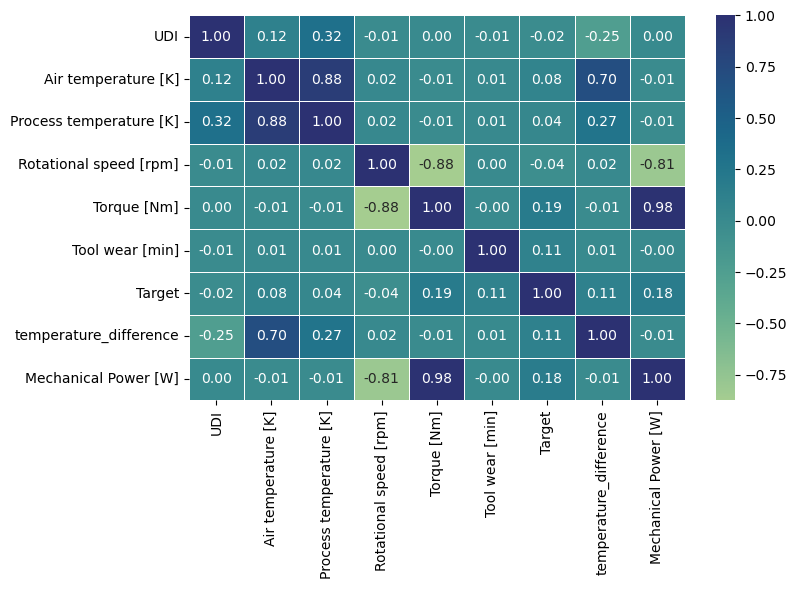

In [48]:
corr_matrix=data.corr(numeric_only=True)
plt.figure(figsize=(8,5))
sns.heatmap(corr_matrix,annot=True,cmap='crest',fmt=".2f", linewidths=0.5)

> **Pregunta 5:** Investiga sobre la matriz de confusión, que interpretas de estos resultados

Aquí podemos ver cuales son las variables que tienen mayor correlación, que entre el rango de [-1,1], nos ayudan a ver que tanta dependencia lineal hay entre las variables. Con esto, determinamos nuestras mayores correlaciones:

Directamente Proporcionales 
- 0.88 para la temperatura ambiente y la temperatura del proceso.
- 0.70 para diferencia de temperatura y temperatura ambiente.
- 0.98 para Torque y Potencia Mecánica.

Inversamente Proporcional
- -0.88 Torque y Velocidad Rotacional
- -0.81 Velocidad Rotacional y Potencia Mecánica.

# Entrenando el Modelo

### Separando el dataset

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X = data.drop(columns=["Target", 'Failure Type', 'Product ID']).copy()
y = data["Target"]

>  Utiliza la función `train_test_split` de sklearn utiliza 20% de los datos para el test set

In [15]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)

## Codificación de variables categoricas

In [16]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [17]:
categorical_cols = ['Type']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [139]:
numerical_cols

['UDI',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'temperature_difference',
 'Mechanical Power [W]']

In [18]:
# Crear preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

# Crear pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Aplicar al dataframe
X_train_transformed = pipeline.fit_transform(X_train)

In [19]:
X_test_transformed = pipeline.transform(X_test)

#### Modelos de ML

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix


In [21]:
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'Logistic Regression CV': LogisticRegressionCV(class_weight='balanced'),
    'SGD': SGDClassifier(class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(), 
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
}


In [22]:
def evaluate_model(X_train, X_test, Y_train, Y_test):
    result = []

    for name, model in models.items():
        print(f"======== Training model: {name} ============")
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)

        # Handle predict_proba or decision_function for ROC AUC
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            y_score = y_pred  # fallback (not ideal)

        roc_auc = roc_auc_score(Y_test, y_score)
        metrics = {
            'precision': precision_score(Y_test, y_pred, zero_division=0),
            'recall': recall_score(Y_test, y_pred, zero_division=0),
            'f1': f1_score(Y_test, y_pred, zero_division=0),
            'roc_auc': roc_auc,
            'cm' : confusion_matrix(Y_test, y_pred)
        }
        print(f"Test data ROC AUC: {roc_auc:.2f}")
        result.append((name, metrics))

    # Sort by F1 score as an example (you can change this to any other metric)
    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [23]:
results = evaluate_model(X_train_transformed,X_test_transformed,Y_train,Y_test)

======== Training model: Logistic Regression ============
Test data ROC AUC: 0.89
======== Training model: Logistic Regression CV ============
Test data ROC AUC: 0.89
======== Training model: SGD ============
Test data ROC AUC: 0.88
======== Training model: Random Forest ============
Test data ROC AUC: 0.94
======== Training model: Gradient Boosting ============
Test data ROC AUC: 0.95
======== Training model: Decision Tree ============
Test data ROC AUC: 0.84


In [ ]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")

Primer entrenamiento:

======== Training model: Logistic Regression ============

- Test data ROC AUC: 0.90

======== Training model: Logistic Regression CV ============

- Test data ROC AUC: 0.90

======== Training model: SGD ============

- Test data ROC AUC: 0.89

======== Training model: Random Forest ============

- Test data ROC AUC: 0.93

======== Training model: Gradient Boosting ============

- Test data ROC AUC: 0.96

======== Training model: Decision Tree ============

- Test data ROC AUC: 0.84

Model Performance:

======== Model: Gradient Boosting ============
- Precision: 0.958333
- Recall:    0.657143
- F1 Score:  0.779661
- ROC AUC:   0.956306

======== Model: Random Forest ============
- Precision: 0.978261
- Recall:    0.642857
- F1 Score:  0.775862
- ROC AUC:   0.925529

======== Model: Decision Tree ============
- Precision: 0.813559
- Recall:    0.685714
- F1 Score:  0.744186
- ROC AUC:   0.840007

======== Model: Logistic Regression CV ============
- Precision: 0.791667
- Recall:    0.271429
- F1 Score:  0.404255
- ROC AUC:   0.904308

======== Model: Logistic Regression ============
- Precision: 0.850000
- Recall:    0.242857
- F1 Score:  0.377778
- ROC AUC:   0.902620

======== Model: SGD ============
- Precision: 0.818182
- Recall:    0.128571
- F1 Score:  0.222222
- ROC AUC:   0.890999

Segundo Entrenamiento

Model Performance:

======== Model: Gradient Boosting ============

- Precision: 0.810345
- Recall:    0.671429
- F1 Score:  0.734375
- ROC AUC:   0.952065

======== Model: Decision Tree ============
- Precision: 0.657534
- Recall:    0.685714
- F1 Score:  0.671329
- ROC AUC:   0.836380

======== Model: Random Forest ============
- Precision: 0.902439
- Recall:    0.528571
- F1 Score:  0.666667
- ROC AUC:   0.944474

======== Model: Logistic Regression CV ============
- Precision: 0.142145
- Recall:    0.814286
- F1 Score:  0.242038
- ROC AUC:   0.894219

======== Model: Logistic Regression ============
- Precision: 0.141439
- Recall:    0.814286
- F1 Score:  0.241015
- ROC AUC:   0.894271

======== Model: SGD ============
- Precision: 0.094755
- Recall:    0.800000
- F1 Score:  0.169440
- ROC AUC:   0.875100

Al utilizar el hiperparámetro *class_weight* obtuvimos menor precisión pero un mejor reconocimiento, por darle prioridad a la clase minoritaria.

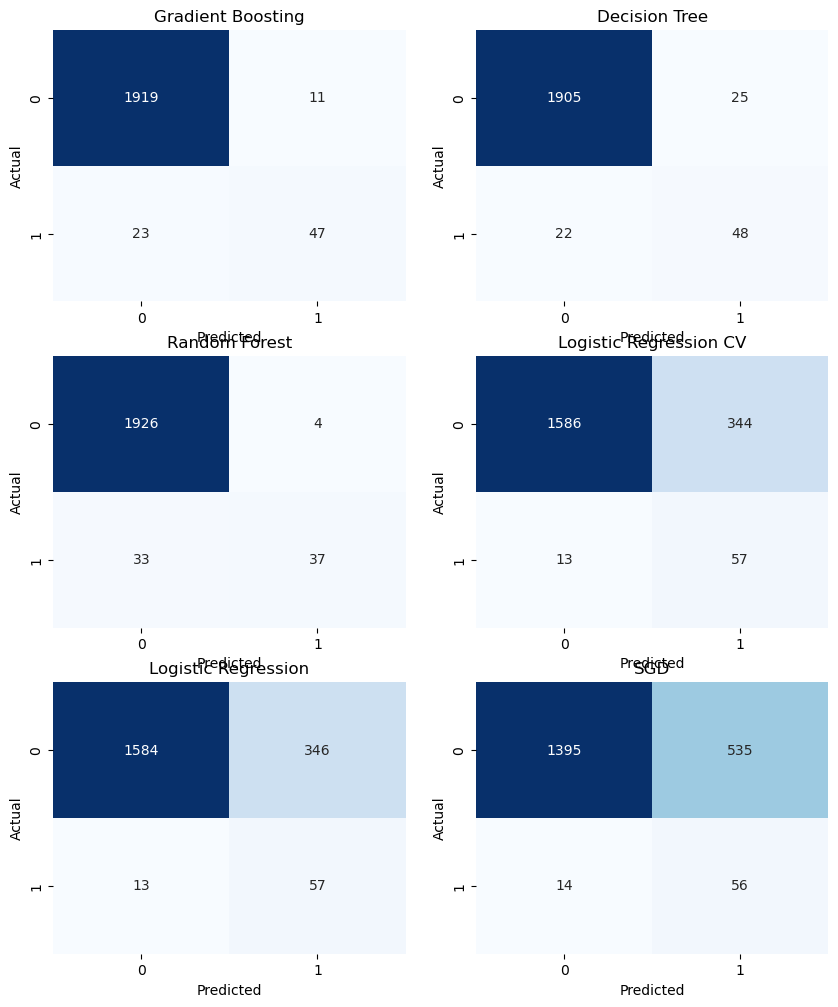

In [25]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 2  # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 6:** Interpreta la matriz de confusión de por lo menos uno de los modelos. ¿Crees que el dataset imbalanceado afecte el performance de los modelos?

Notemos como luego de usar el balanceo para el modelo, mejora significantemente los resultados con *Random Tree Forest*, pues tenemos bajos falsos positivos y bajos falsos negativos. Este modelo es mucho más preciso, pues acapara la mayoría en verdaderos negativos, que es el caso para nuestro dataset.

Ahora, claro que afecta el performance de los modelos, pues podemos tener modelos muy precisos cuando tenemos clases minoritarias, como en el caso de nuestro dataset.

### Balanceo de datos

Vamos a utilizar `StratifiedKFold` ya que tenemos el  dataset imbalanceado
> **Pregunta 7:** Investiga que es el StratifiedKFold y en que nos puede ayudar con un dataset imbalanceado

El *StratifiedKFold* entrena al modelo porcionando el dataset y preservando la proporción entre clases, entre cada uno de ellos, llegando así a entrenar de nuna manear más concisa al modelo. En este caso, que tenemos un dataset desbalanceado, podemos ayudarlo para que no tenga falsas métricas tan altas. 

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
def evaluate_model_cv(X, y, pipeline, models, n_splits=5):
    result = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"======== Evaluating model: {name} with {n_splits}-Fold Stratified CV ============")
        
        fold_metrics = {'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
        confusion_matrices = []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            Y_train, Y_test = y.iloc[train_idx], y.iloc[test_idx]
            
            X_train = pipeline.transform(X_train)
            X_test = pipeline.transform(X_test)
            
            model.fit(X_train, Y_train)
            y_pred = model.predict(X_test)

            # ROC AUC input
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_score = model.decision_function(X_test)
            else:
                y_score = y_pred

            # Collect metrics
            fold_metrics['precision'].append(precision_score(Y_test, y_pred, zero_division=0))
            fold_metrics['recall'].append(recall_score(Y_test, y_pred, zero_division=0))
            fold_metrics['f1'].append(f1_score(Y_test, y_pred, zero_division=0))
            fold_metrics['roc_auc'].append(roc_auc_score(Y_test, y_score))
            confusion_matrices.append(confusion_matrix(Y_test, y_pred))

            print(f"  Fold {fold} - F1: {fold_metrics['f1'][-1]:.2f}, AUC: {fold_metrics['roc_auc'][-1]:.2f}")

        # Aggregate average metrics
        avg_metrics = {
            'precision': np.mean(fold_metrics['precision']),
            'recall': np.mean(fold_metrics['recall']),
            'f1': np.mean(fold_metrics['f1']),
            'roc_auc': np.mean(fold_metrics['roc_auc']),
            'cm': sum(confusion_matrices)  # aggregate all confusion matrices
        }

        result.append((name, avg_metrics))

    # Sort models by F1
    result.sort(key=lambda x: x[1]['f1'], reverse=True)
    return result

In [30]:
results = evaluate_model_cv(X, y, pipeline, models)

======== Evaluating model: Logistic Regression with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.22, AUC: 0.89
  Fold 2 - F1: 0.23, AUC: 0.89
  Fold 3 - F1: 0.23, AUC: 0.91
  Fold 4 - F1: 0.25, AUC: 0.91
  Fold 5 - F1: 0.24, AUC: 0.89
======== Evaluating model: Logistic Regression CV with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.22, AUC: 0.89
  Fold 2 - F1: 0.23, AUC: 0.89
  Fold 3 - F1: 0.23, AUC: 0.91
  Fold 4 - F1: 0.25, AUC: 0.91
  Fold 5 - F1: 0.23, AUC: 0.89
======== Evaluating model: SGD with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.16, AUC: 0.85
  Fold 2 - F1: 0.16, AUC: 0.80
  Fold 3 - F1: 0.27, AUC: 0.91
  Fold 4 - F1: 0.37, AUC: 0.91
  Fold 5 - F1: 0.19, AUC: 0.82
======== Evaluating model: Random Forest with 5-Fold Stratified CV ============
  Fold 1 - F1: 0.71, AUC: 0.98
  Fold 2 - F1: 0.68, AUC: 0.96
  Fold 3 - F1: 0.65, AUC: 0.96
  Fold 4 - F1: 0.69, AUC: 0.96
  Fold 5 - F1: 0.58, AUC: 0.95
======== Evaluating model: Gradient Boosting with 5-Fol

In [32]:
print("Model Performance:")
for name, metrics in results:
    print(f"======== Model: {name} ============")
    print(f"  Precision: {metrics['precision']:.6f}")
    print(f"  Recall:    {metrics['recall']:.6f}")
    print(f"  F1 Score:  {metrics['f1']:.6f}")
    print(f"  ROC AUC:   {metrics['roc_auc']:.6f}")

Model Performance:
======== Model: Gradient Boosting ============
  Precision: 0.871008
  Recall:    0.661018
  F1 Score:  0.747896
  ROC AUC:   0.971609
======== Model: Random Forest ============
  Precision: 0.914423
  Recall:    0.522300
  F1 Score:  0.660586
  ROC AUC:   0.961242
======== Model: Decision Tree ============
  Precision: 0.644226
  Recall:    0.596005
  F1 Score:  0.615866
  ROC AUC:   0.792051
======== Model: Logistic Regression ============
  Precision: 0.137136
  Recall:    0.817032
  F1 Score:  0.234761
  ROC AUC:   0.899501
======== Model: Logistic Regression CV ============
  Precision: 0.136416
  Recall:    0.817032
  F1 Score:  0.233732
  ROC AUC:   0.899064
======== Model: SGD ============
  Precision: 0.142794
  Recall:    0.755356
  F1 Score:  0.229971
  ROC AUC:   0.858153


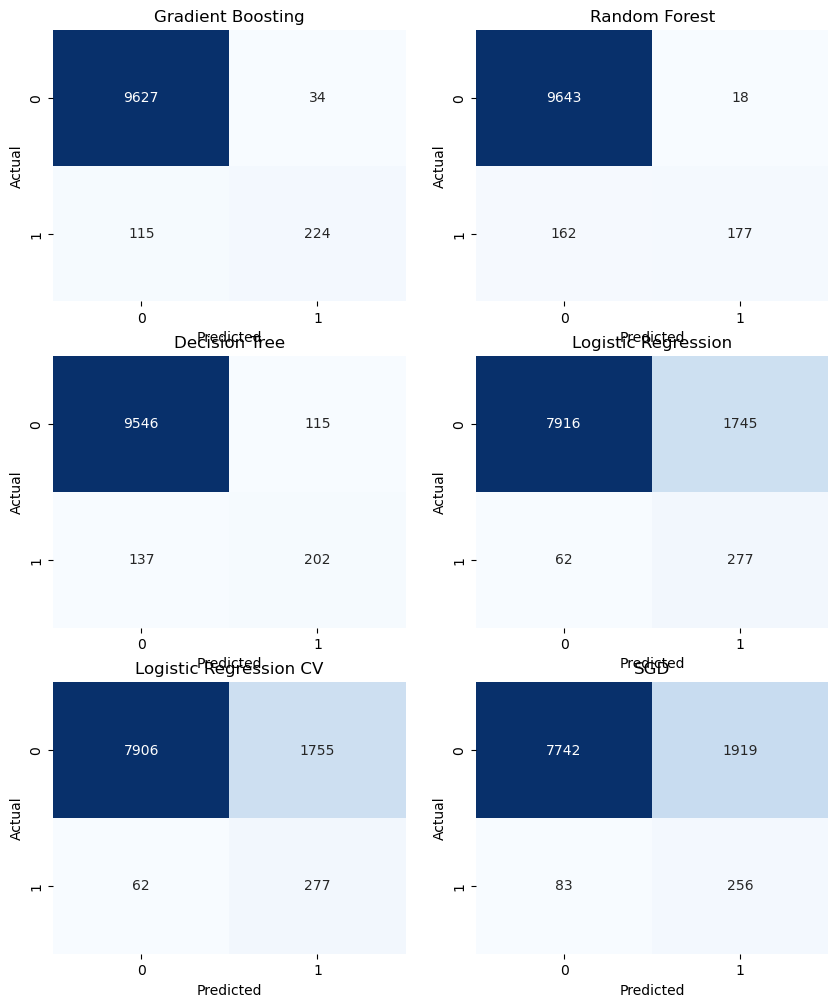

In [33]:
 # Plot all confusion matrices as subplots
n_models = len(metrics)
cols = 2  # You can change this based on your preference
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()  # Flatten in case of 2D array

for idx, (name, metrics) in enumerate(results):
    cm=metrics["cm"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

> **Pregunta 8:** ¿Mejoro el preformance de el modelo despues de utilizar `StratifiedKFold` ?

Mejoró absurdamente, considerando que tenemos 10,000 muestras, pudiendo encontrar para todos los modelos, más de 7,000 casos sin falla, los cuales deben serlo, y aumentando significativamente los verdaderos positivos. Este método realmente optimizó a los modelos y lso de forest y random tree son los que se desempeñan mejor. 